In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
train_data_orig = pd.read_csv('C:\\Users\\marku\\Documents\\SteelProdData_Project\\data\\raw\\normalized_train_data.csv')
test_data_orig = pd.read_csv('C:\\Users\\marku\\Documents\\SteelProdData_Project\\data\\raw\\normalized_test_data.csv')


In [9]:
conc_data=pd.concat([train_data_orig, test_data_orig], ignore_index=True)

In [10]:
#Replace missing values with mean of the columns
numerical_cols = conc_data.select_dtypes(include=np.number).columns.tolist() 
conc_data[numerical_cols] = conc_data[numerical_cols].apply(lambda x: x.fillna(x.mean()), axis=0) # Fill NaN with column mean

In [11]:
#Check for missing values

# Define a set of values that should be treated as empty/missing
EMPTY_TOKENS = {"", " ", "NA", "N/A", "null", "None", "nan", "-"}

# Create a copy of the dataframe to avoid modifying the original
conc_data_check = conc_data.copy()

# Convert empty strings and placeholder values to NaN in object columns
obj_cols = conc_data_check.select_dtypes(include=["object"]).columns
for c in obj_cols:
    conc_data_check[c] = (
        conc_data_check[c]
        .astype(str)        # Convert all values to strings
        .str.strip()        # Remove leading/trailing whitespace
        .replace(EMPTY_TOKENS, np.nan)  # Replace empty tokens with NaN
    )

# Create a summary dataframe with statistics about each column
summary = pd.DataFrame({
    "dtype": conc_data_check.dtypes.astype(str),      # Data type of each column
    "rows_total": len(conc_data_check),               # Total number of rows
    "non_null": conc_data_check.notna().sum(),        # Count of non-null values
    "nulls": conc_data_check.isna().sum(),            # Count of null values
    "null_frac": (conc_data_check.isna().mean()),     # n_NaN/n_all_Entries
    "n_unique": conc_data_check.nunique(dropna=True), # Count of unique non-null values
})
# Sort the summary by null fraction
summary = summary.sort_values("null_frac", ascending=False)


display(summary)

,dtype,rows_total,non_null,nulls,null_frac,n_unique
output,float64,10979,10979,0,0.0,250
input1,float64,10979,10979,0,0.0,5
input20,float64,10979,10979,0,0.0,51
input19,float64,10979,10979,0,0.0,210
input18,float64,10979,10979,0,0.0,42
input17,float64,10979,10979,0,0.0,164
input16,float64,10979,10979,0,0.0,70
input15,float64,10979,10979,0,0.0,44
input14,float64,10979,10979,0,0.0,55
input13,float64,10979,10979,0,0.0,76


In [12]:
#Check for duplicates

# Count duplicate rows based on all input and output columns
n_dup = conc_data_check.duplicated().sum()
print(f"Duplikate über input1..input21 + output: {n_dup}")

# Display duplicate rows
dup_rows = conc_data_check[conc_data_check.duplicated(keep=False)].copy()

display(dup_rows.head(5))  # Display first 5 duplicate rows


Duplikate über input1..input21 + output: 0


,output,input1,input2,input3,input4,input5,input6,input7,input8,input9,...,input12,input13,input14,input15,input16,input17,input18,input19,input20,input21


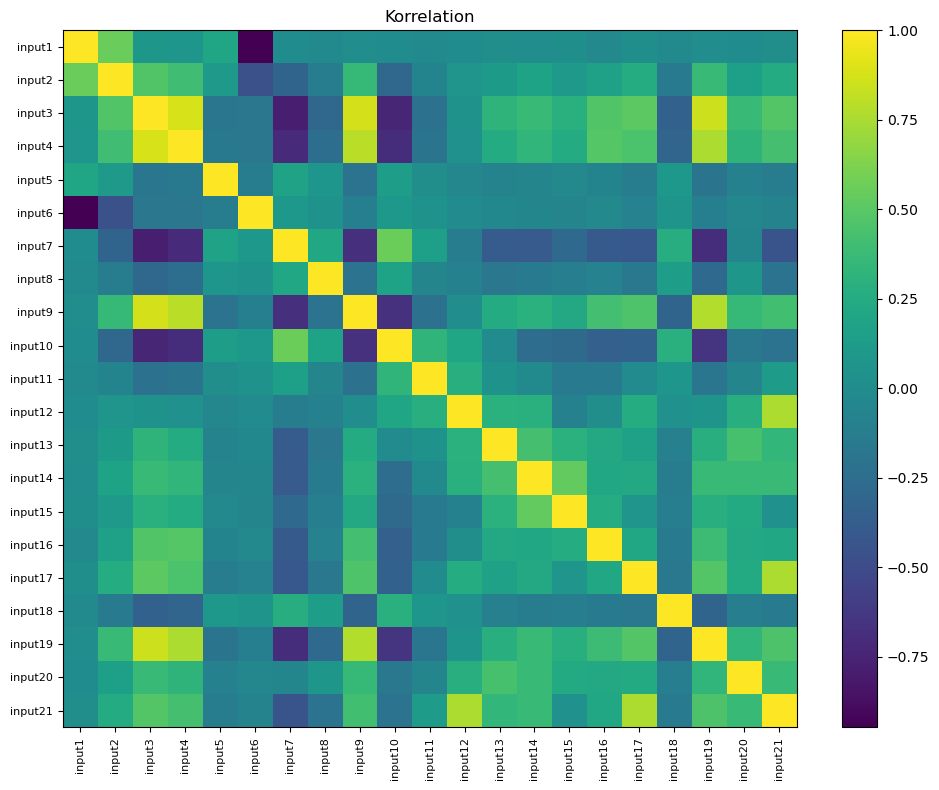

In [13]:


num_cols = conc_data.select_dtypes(include=["number"]).columns.tolist()
num_cols.remove("output")                             #Remove column output from correlation analysis


corr_cols = num_cols[:] 
corr = conc_data[corr_cols].corr()  
plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.title("Korrelation")
plt.colorbar()

plt.xticks(range(len(corr_cols)), corr_cols, rotation=90, fontsize=8)
plt.yticks(range(len(corr_cols)), corr_cols, fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

g=sns.pairplot(conc_data.sample(n=300, random_state=42)) #Plot pairwise relationships with sample of 300 rows

In [ ]:
plt.hist(conc_data["output"])

In [14]:
#Test/Train_Split
X=conc_data.drop("output", axis=1 ).values
y=conc_data["output"].values


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=35)

X

array([[0.        , 0.5703125 , 0.77844311, ..., 0.07932961, 0.49685535,
        0.51176983],
       [0.        , 0.57421875, 0.78443114, ..., 0.08156425, 0.48427673,
        0.45074106],
       [0.        , 0.58984375, 0.78293413, ..., 0.08268156, 0.47169811,
        0.48561465],
       ...,
       [1.        , 0.81640625, 0.37886598, ..., 0.00640809, 0.43495401,
        0.58276334],
       [1.        , 0.83984375, 0.37564433, ..., 0.00809444, 0.44809461,
        0.61696306],
       [1.        , 0.80078125, 0.375     , ..., 0.00966835, 0.48751643,
        0.59644323]], shape=(10979, 21))

In [ ]:
#Establish Baseline Model with Linear Regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
#s=StandardScaler()       #Data is standardized using Min-Max Scaling
#s.fit(X_train) 

#X_train_trans= s.transform(X_train) 
#X_test_trans=s.transform(X_test)

model=LinearRegression()

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

In [ ]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor()

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

In [48]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(21,),kernel_regularizer=regularizers.l2(1e-4))) #21 Inputs
model.add(layers.BatchNormalization())


model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(layers.BatchNormalization())



model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1,activation='linear'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae','mse'])



c:\Users\marku\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,    # Cut LR by 80% when progress stalls
    patience=7, 
    min_lr=1e-7,
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,          # Increased epochs to allow LR scheduler to work
    batch_size=128,      # Larger batch size can stabilize gradients for normalized data
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/200


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0388 - mae: 0.1873 - mse: 0.0712 - val_loss: 0.0407 - val_mae: 0.2567 - val_mse: 0.0746 - learning_rate: 0.0010
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - mae: 0.1010 - mse: 0.0168 - val_loss: 0.0163 - val_mae: 0.1408 - val_mse: 0.0261 - learning_rate: 0.0010
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - mae: 0.0852 - mse: 0.0119 - val_loss: 0.0108 - val_mae: 0.1026 - val_mse: 0.0152 - learning_rate: 0.0010
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - mae: 0.0812 - mse: 0.0108 - val_loss: 0.0089 - val_mae: 0.0860 - val_mse: 0.0117 - learning_rate: 0.0010
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mae: 0.0772 - mse: 0.0098 - val_loss: 0.0079 - val_mae: 0.0773 - val_mse: 0.0099 - learning_rate: 0.0010
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - mae: 0.0731 - mse: 0.0088 - val_loss: 0.0077 - val_mae: 0.0747 - val_mse: 0.009

In [50]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test) 
r2 = r2_score(y_test, y_pred)
print("R²_valid:", r2)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R²_valid: 0.43968661795599695


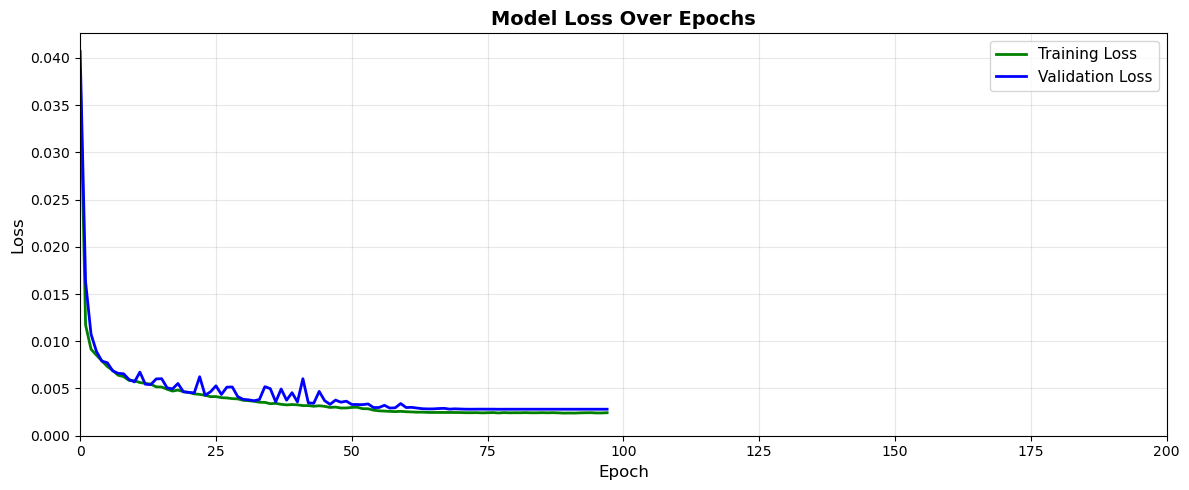

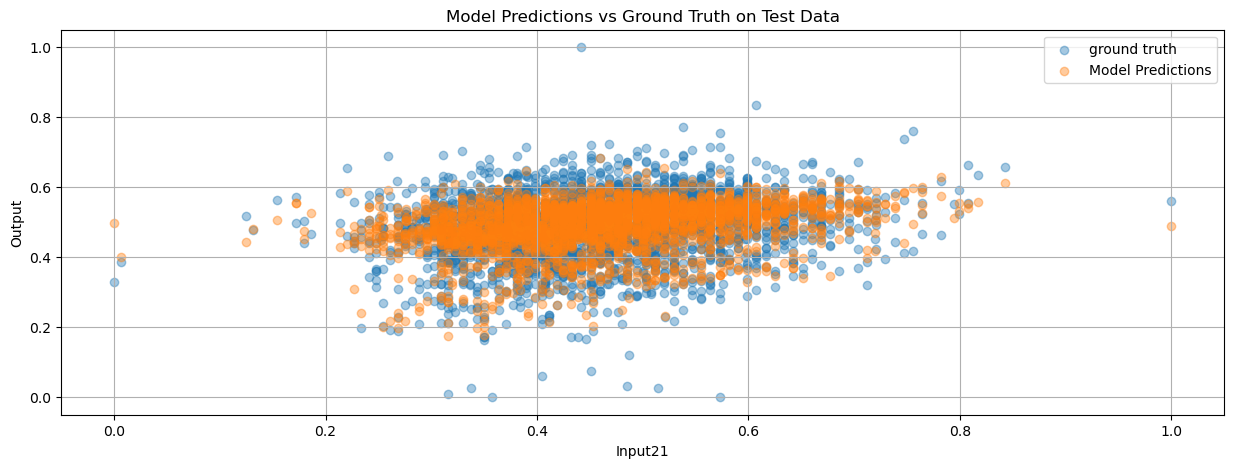

In [51]:
import sys
sys.path.append(r"C:\Users\marku\Documents\SteelProdData_Project\src\scripts")
from plot_helper import plot_loss, plot_data

plot_loss(history)
plot_data(X_test, y_test, y_pred, title="Model Predictions vs Ground Truth on Test Data")